In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw
import time
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as ss
%matplotlib notebook

16:07:21 [I] klustakwik KlustaKwik2 version 0.2.6


### Create toy example dataset

In [3]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=30)

### Filtering

Now apply a bandpass filter and a notch filter (separately) to the recording extractor. Filters are also RecordingExtractor objects.

In [4]:
recording_bp = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_notch = st.preprocessing.notch_filter(recording, freq=1000, q=10)

Notch filter at:  1000


Now let's plot the power spectrum of non-filtered, bandpass filtered, and notch filtered recordings.

In [5]:
f_raw, p_raw = ss.welch(recording.get_traces(), fs=recording.get_sampling_frequency())
f_bp, p_bp = ss.welch(recording_bp.get_traces(), fs=recording.get_sampling_frequency())
f_notch, p_notch = ss.welch(recording_notch.get_traces(), fs=recording.get_sampling_frequency())

/home/alessiob/anaconda3/envs/expipe/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


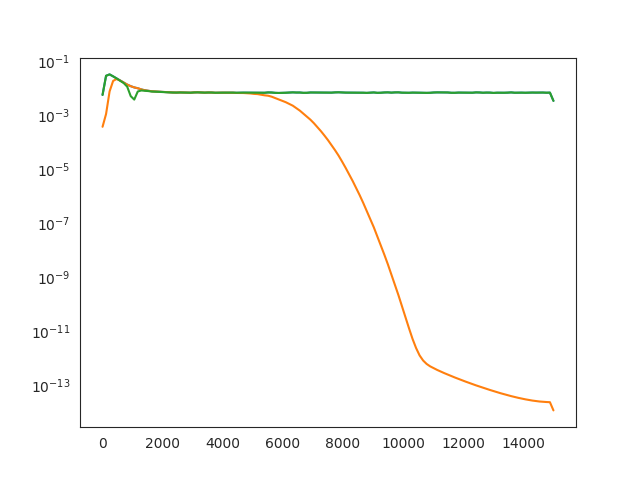

In [6]:
plt.figure()
plt.semilogy(f_raw, p_raw[0], f_bp, p_bp[0], f_notch, p_notch[0])

### Extracting LFP and MUA

Local field potentials (LFP) are low frequency components of the extracellular recordings.
Multi-unit activity (MUA) are rectified and low-pass filtered recordings showing the diffuse spiking activity.

In `spiketoolkit`, LFP and MUA can be extracted combining the `bandpass_filter`, `rectify` and `resample` functions. In this example LFP and MUA are resampled at 1000 Hz.

In [7]:
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=1, freq_max=300)
recording_lfp = st.preprocessing.resample(recording_lfp, 1000)
recording_mua = st.preprocessing.resample(st.preprocessing.rectify(recording), 1000)

The toy example data are only contain high frequency components, but these lines of code will work on experimental data

### Changing the reference

In many cases, before spike sorting, it is wise to re-reference the signals to reduce the common-mode noise from the recordings.

To re-reference in `spiketoolkit` you can use the `common_reference` function. Both common average reference (CAR) and common median reference (CMR) can be applied. Moreover, the average/median can be computed on different groups. Single channels can also be used as reference.

In [8]:
recording_car = st.preprocessing.common_reference(recording, reference='average')
recording_cmr = st.preprocessing.common_reference(recording, reference='median')
recording_single = st.preprocessing.common_reference(recording, reference='single', ref_channel=0)
recording_single_groups = st.preprocessing.common_reference(recording, reference='single', groups=[[0,1], [2,3]], 
                                                            ref_channel=[0,2])

<IPython.core.display.Javascript object>


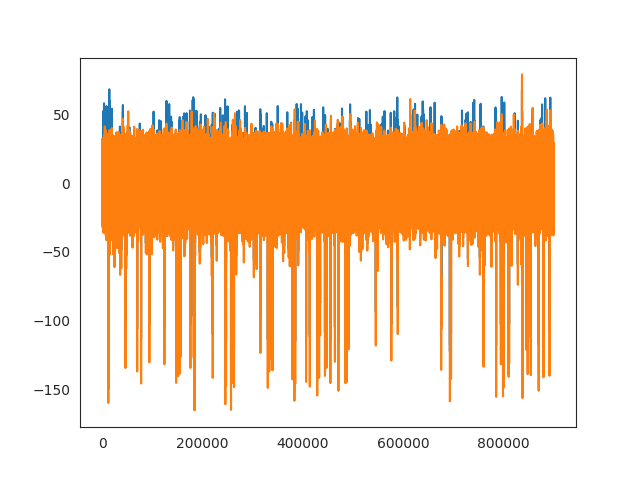

<IPython.core.display.Javascript object>


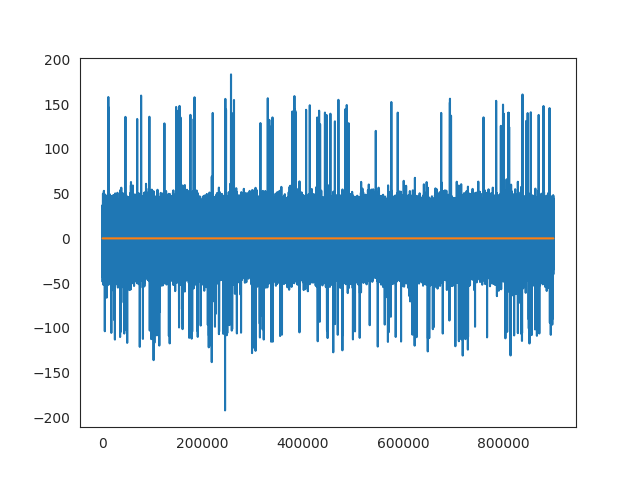

Common average in groups:  [[0, 1], [2, 3]]
Common average in groups:  [[0, 1], [2, 3]]


In [9]:
plt.figure()
plt.plot(recording_car.get_traces()[0])
plt.plot(recording_cmr.get_traces()[0])
plt.figure()
plt.plot(recording_single_groups.get_traces()[1]) # not zero
plt.plot(recording_single_groups.get_traces()[0])

### Remove stimulation artifacts

In some applications, electrodes are used to electrically stimulate the tissue, generating a large artifact.
In `spiketoolkit`, the artifact can be zeroed-out using the `remove_artifact` function.

In [10]:
# create dummy stimulation triggers
stimulation_trigger_frames = np.array([100000, 500000, 700000])

In [11]:
# large ms_before and s_after are used for plotting only
recording_rmartifact = st.preprocessing.remove_artifacts(recording, 
                                                         triggers=stimulation_trigger_frames, 
                                                         ms_before=100, ms_after=200)

<IPython.core.display.Javascript object>


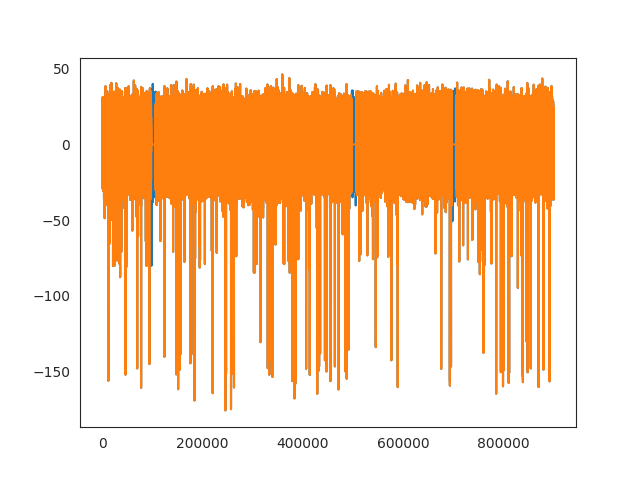

In [12]:
plt.figure()
plt.plot(recording.get_traces()[0])
plt.plot(recording_rmartifact.get_traces()[0])

After the proper preprocessing step, you are ready to run spike sorting!